K fold: 10 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)


ModuleNotFoundError: No module named 'keras'

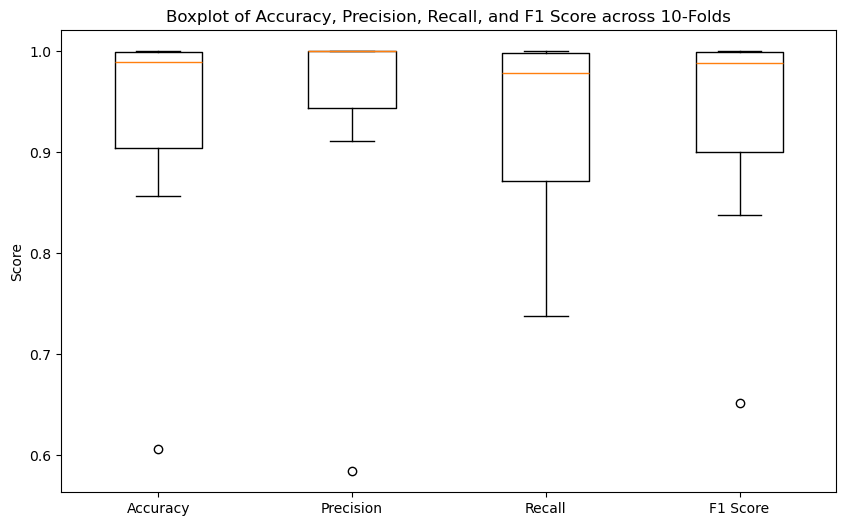

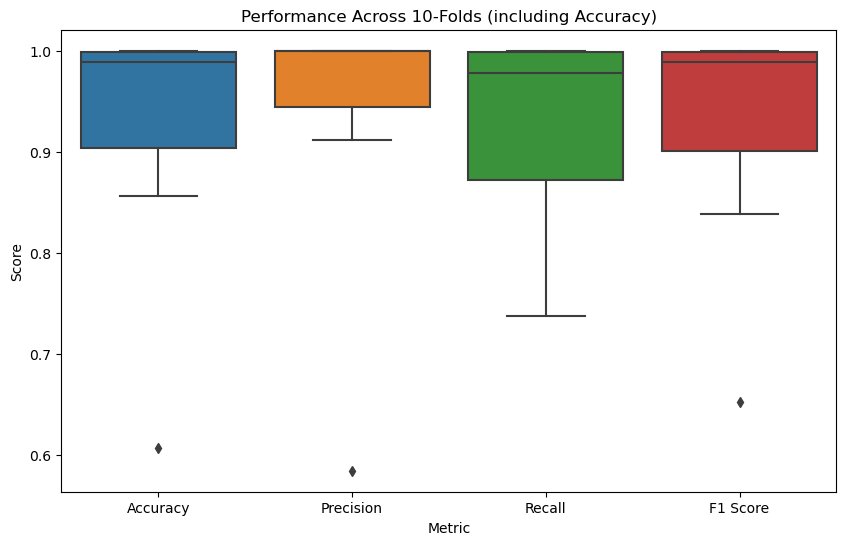


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
Accuracy     0.606250   0.924687        1.0
F1 Score     0.651934   0.926927        1.0
Precision    0.584158   0.939400        1.0
Recall       0.737500   0.919375        1.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Data
accuracy_list = [0.606250, 0.856250, 0.903125, 0.906250, 1.000000, 0.996875, 0.981250, 1.000000, 0.996875, 1.000000]  # Replace with your actual accuracy values
precision_list = [0.584158, 0.959677, 0.938776, 0.911392, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall_list = [0.7375, 0.74375, 0.8625, 0.9, 1.0, 0.99375, 0.9625, 1.0, 0.99375, 1.0]
f1_list = [0.651934, 0.838028, 0.899023, 0.90566, 1.0, 0.996865, 0.980892, 1.0, 0.996865, 1.0]

# Combine the lists into a single list of lists
data = [accuracy_list, precision_list, recall_list, f1_list]  # Include accuracy in the data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Accuracy', 'Precision', 'Recall', 'F1 Score'])  # Adjust the labels

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Accuracy, Precision, Recall, and F1 Score across 10-Folds')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 4),  # Adjust the repeat value
    'Metric': ['Accuracy'] * 10 + ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,  # Adjust the categories
    'Score': accuracy_list + precision_list + recall_list + f1_list  # Include accuracy in the scores
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds (including Accuracy)')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)


K fold: 5 Folds, 80% training, 20% testing split. (4 HI, 4 NH for testing, and rest for training)

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


ModuleNotFoundError: No module named 'keras'

1-11-23
This code below is for K fold: 5 folds, 80%-20% train/test split, but it includes evluation metrics, boxplot and summary table 

UPDATE: THIS IS THE ONE FOR 5 FOLD!

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/5folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 6):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)


# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 6),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


import matplotlib.pyplot as plt


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

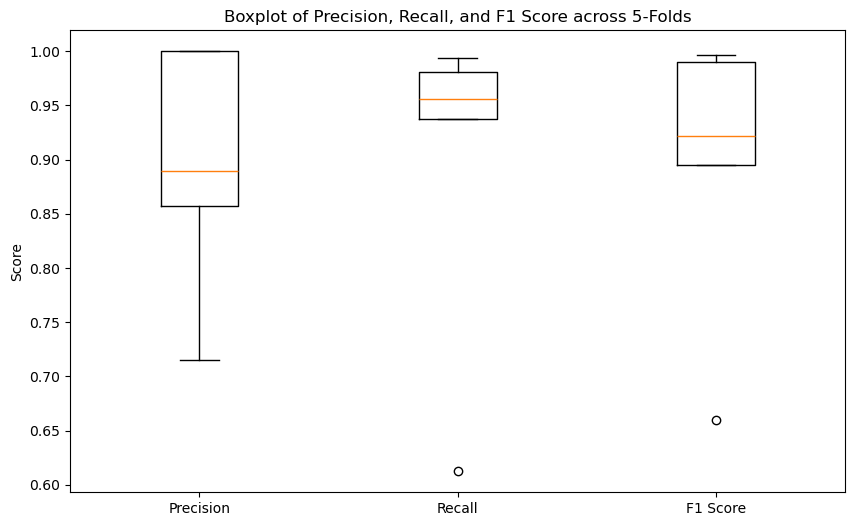

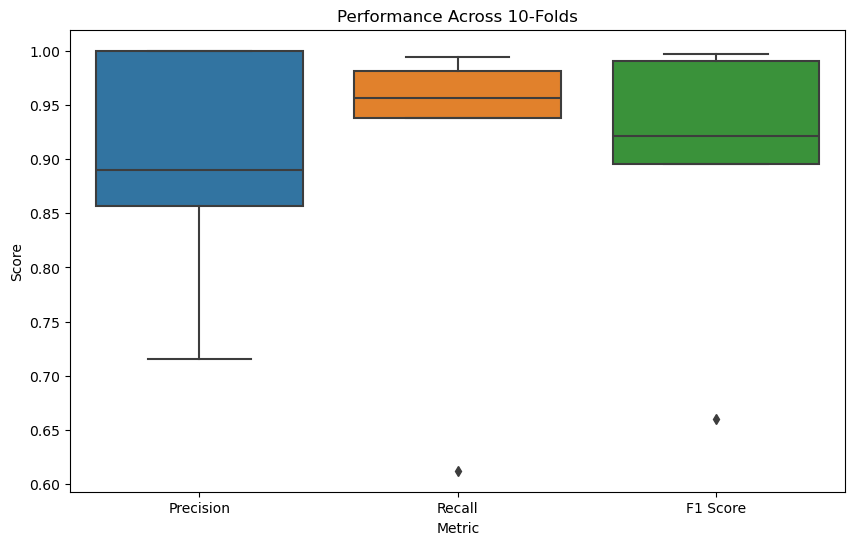


Summary of Results:
           Worst Fold  Avg. Fold  Best Fold
Metric                                     
F1 Score     0.659933   0.892909   0.996865
Precision    0.715328   0.892401   1.000000
Recall       0.612500   0.896250   0.993750


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Data
accuracy_list = [0.684375, 0.890625, 0.918750, 0.990625, 0.996875]  # Replace with your actual accuracy values
precision_list = [0.7153284671532847, 0.8571428571428571, 0.8895348837209303, 1.0, 1.0]
recall_list = [0.6125, 0.9375, 0.95625, 0.98125, 0.99375]
f1_list = [0.6599326599326599, 0.8955223880597014, 0.9216867469879518, 0.9905362776025236, 0.9968652037617556]

# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score across 5-Folds')

# Show the plot
plt.show()
# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 6), 3),
    'Metric': ['Precision'] * 5 + ['Recall'] * 5 + ['F1 Score'] * 5,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 10-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)

1-13-23:
Save Model Checkpoints:
SCRIPT BELOW CAN BE USED FOR INDEPDENT FOLDS (5 10, ANY)
10 folds INDEPENDENT OF 5 FOLDS
Investigate and implement a mechanism to save model checkpoints during training, ensuring essential information is included.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(1, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

1-16-23
10 fold based on 5 fold model (dependent training)

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 80-20 train test split'


# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Load the entire model from the file
model = load_model('/home/wangg/REU-Hearing-Loss-Project-1/machine learning/checkpoint results/10 folds 80_20 split/dependentModel/model/10fold_model_fold_5.h5')


# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(6, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(6, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'

In [8]:
import os

# Print the current working directory
print("Current Working Directory:", os.getcwd())
print("Results File Location:", os.path.abspath(results_filename))


Current Working Directory: /home/wangg/REU-Hearing-Loss-Project-1/machine learning


NameError: name 'results_filename' is not defined

K fold: 10 Folds, 90% training, 10% testing split. (2 HI, 2 NH for testing, and rest for training)

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project/machine learning/allFolds/10folds- 90-10 train test split'  # Change this to the root folder containing your k-fold data

# CNN Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Create the CNN model
model = build_model(input_shape)
model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []

for fold_number in range(1, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-5: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-5: {std_accuracy}')


ModuleNotFoundError: No module named 'keras'

In [10]:

# Traverse through fold_accuracies and print them
print("Accuracies for each fold:")
for fold_number, accuracy in enumerate(fold_accuracies, start=1):
    print(f'Fold {fold_number}: {accuracy}')

average_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\nAverage Accuracy across Folds 1-10: {average_accuracy}')
print(f'Standard Deviation of Accuracy across Folds 1-10: {std_accuracy}')


Accuracies for each fold:


NameError: name 'fold_accuracies' is not defined

K fold for all subjects (10 fold): EACH FOLD MODEL SHOULD BE INDEPENDENT OF EACH OTHER

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'

# CNN Model
def build_model(input_shape, learning_rate = 0.001):
    # model = Sequential()
    # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D((2, 2)))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(2, activation='softmax'))
    # optimizer = Adam(learning_rate=learning_rate)
    # model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    # return model

    # apply weight decay
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# # Create the CNN model
# model = build_model(input_shape)
# model.summary()

# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

for fold_number in range(1, 11):
    # Create the CNN model
    model = build_model(input_shape, learning_rate=0.001)
    model.summary()
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(1, 10),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# # Create a DataFrame for easy summary and visualization
# df_results = pd.DataFrame({
#     'Fold': np.repeat(range(1, 11), 3),
#     'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
#     'Score': precision_list + recall_list + f1_list
# })

# # Visualize the results with a single boxplot
# plt.figure(figsize=(10, 6))
# sns.boxplot(x='Metric', y='Score', data=df_results)
# plt.title('Performance Across 5-Folds')
# plt.show()

# # Summary table
# summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
# summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
# print("\nSummary of Results:")
# print(summary_table)



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

2024-01-23 17:17:21.805484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 26s 553ms/step - loss: 0.8773 - accuracy: 0.6285
Epoch 2/60
45/45 [==============================] - 26s 582ms/step - loss: 0.6276 - accuracy: 0.7104
Epoch 3/60
45/45 [==============================] - 25s 543ms/step - loss: 0.5587 - accuracy: 0.7528
Epoch 4/60
45/45 [==============================] - 26s 568ms/step - loss: 0.5365 - accuracy: 0.7729
Epoch 5/60
45/45 [==============================] - 27s 584ms/step - loss: 0.5590 - accuracy: 0.7556
Epoch 6/60
45/45 [==============================] - 25s 546ms/step - loss: 0.5222 - accuracy: 0.7549
Epoch 7/60
45/45 [==============================] - 26s 576ms/step - loss: 0.5042 - accuracy: 0.7854
Epoch 8/60
45/45 [==============================] - 25s 554ms/step - loss: 0.4487 - accuracy: 0.8174
Epoch 9/60
45/45 [==============================] - 25s 557ms/step - loss: 0.4351 - accuracy: 0.8250
Epoch 10/60
45/45 [==============================] - 26s 567ms/step - loss: 0.3830 - accuracy: 0.8521


2024-01-23 17:45:23.413471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 248ms/step - loss: 2.1279 - accuracy: 0.6875

Evaluation for Fold 1:
Test Loss: 2.1279146671295166
Test Accuracy: 0.6875


2024-01-23 17:45:27.008757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 244ms/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 17:45:34.055155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 28s 577ms/step - loss: 1.0014 - accuracy: 0.6118
Epoch 2/60
45/45 [==============================] - 25s 555ms/step - loss: 0.6255 - accuracy: 0.7208
Epoch 3/60
45/45 [==============================] - 27s 581ms/step - loss: 0.5636 - accuracy: 0.7535
Epoch 4/60
45/45 [==============================] - 24s 528ms/step - loss: 0.5190 - accuracy: 0.7875
Epoch 5/60
45/45 [==============================] - 21s 464ms/step - loss: 0.4926 - accuracy: 0.8007
Epoch 6/60
45/45 [==============================] - 27s 603ms/step - loss: 0.4843 - accuracy: 0.7910
Epoch 7/60
45/45 [==============================] - 25s 546ms/step - loss: 0.3952 - accuracy: 0.8514
Epoch 8/60
45/45 [==============================] - 25s 547ms/step - loss: 0.3993 - accuracy: 0.8514
Epoch 9/60
45/45 [==============================] - 24s 532ms/step - loss: 0.3374 - accuracy: 0.8799
Epoch 10/60
45/45 [==============================] - 25s 547ms/step - loss: 0.3266 - accuracy: 0.8854


2024-01-23 18:15:27.438823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 254ms/step - loss: 1.8745 - accuracy: 0.6719

Evaluation for Fold 2:
Test Loss: 1.8744878768920898
Test Accuracy: 0.671875


2024-01-23 18:15:30.727929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


10/10 [==============================] - 3s 236ms/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 

2024-01-23 18:15:34.942288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


45/45 [==============================] - 28s 582ms/step - loss: 1.4141 - accuracy: 0.5243
Epoch 2/60
45/45 [==============================] - 41s 902ms/step - loss: 0.7034 - accuracy: 0.6556
Epoch 3/60
45/45 [==============================] - 41s 896ms/step - loss: 0.6322 - accuracy: 0.7229
Epoch 4/60
45/45 [==============================] - 40s 891ms/step - loss: 0.6364 - accuracy: 0.7083
Epoch 5/60
45/45 [==============================] - 35s 763ms/step - loss: 0.5490 - accuracy: 0.7694
Epoch 6/60
45/45 [==============================] - 31s 693ms/step - loss: 0.5417 - accuracy: 0.7646
Epoch 7/60
45/45 [==============================] - 41s 907ms/step - loss: 0.5068 - accuracy: 0.7910
Epoch 8/60
45/45 [==============================] - 40s 886ms/step - loss: 0.4888 - accuracy: 0.7861
Epoch 9/60
45/45 [==============================] - 42s 933ms/step - loss: 0.4566 - accuracy: 0.8056
Epoch 10/60
45/45 [==============================] - 41s 895ms/step - loss: 0.4468 - accuracy: 0.8160


In [12]:
# Given values
fold_accuracies = [0.715624988079071, 0.6312500238418579, 0.550000011920929, 0.4593749940395355,
                   0.534375011920929, 0.46562498807907104, 0.6000000238418579, 0.4437499940395355,
                   0.668749988079071, 0.659375011920929]

# Calculate the average
average_accuracy = sum(fold_accuracies) / len(fold_accuracies)

# Print the result
print("Average Accuracy:", average_accuracy)


Average Accuracy: 0.5728125035762787


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_fscore_support
import pickle
from keras.models import load_model


# Path to the data directories
fold_data_dir = '/home/wangg/REU-Hearing-Loss-Project-1/machine learning/allFolds/10folds - 80-20 train test split (includes all subjects)'


# Dimensions of the images (224x224 with 3 channels)
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
# Load the entire model from the file
model = load_model('/home/wangg/REU-Hearing-Loss-Project-1/machine learning/checkpoint results/10folds - 80-20 train test split (includes all subjects)/model/10fold_model_fold_3.h5')


# Data generator for training and testing (no validation)
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Lists to store results for each fold
fold_accuracies = []
precision_list = []
recall_list = []
f1_list = []

# JUST TRY THIS ON ONE FOLD FIRST
for fold_number in range(4, 11):
    # Update fold path 
    fold_path = os.path.join(fold_data_dir, f'fold{fold_number}')

    # Training data
    train_data_dir = os.path.join(fold_path, 'Training')
    print(f"\nFold {fold_number} - Training Data Directory:", train_data_dir)
    
    train_generator = data_generator.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical')

    print("Number of Training Samples:", train_generator.samples)

    # Testing data
    test_data_dir = os.path.join(fold_path, 'Testing')
    print(f"\nFold {fold_number} - Testing Data Directory:", test_data_dir)

    test_generator = data_generator.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

    print("Number of Test Samples:", test_generator.samples)

    # Training the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=60)

    # Save the model after training
    model.save(f'10fold_model_fold_{fold_number}.h5')

    # Load the saved model for testing
    loaded_model = load_model(f'10fold_model_fold_{fold_number}.h5')

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
    print(f'\nEvaluation for Fold {fold_number}:')
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Store the accuracy for this fold
    fold_accuracies.append(test_accuracy)

    # Evaluate precision, recall, and F1 score
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    true_labels = np.argmax(test_generator.labels, axis=1) if len(test_generator.labels.shape) > 1 else test_generator.labels
    predicted_labels = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='binary')

    # Store the results for this fold
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

     # Save classification results to a file
    results_filename = f'10fold_classification_results_fold_{fold_number}.txt'
    with open(results_filename, 'w') as results_file:
        results_file.write("Image Name\tTrue Label\tPredicted Label\n")
        for i in range(len(test_generator.filenames)):
            image_name = os.path.basename(test_generator.filenames[i])
            true_label = true_labels[i]
            predicted_label = predicted_labels[i]
            results_file.write(f"{image_name}\t{true_label}\t{predicted_label}\n")

# Save precision, recall, and f1_list to a file
results = {
    'precision_list': precision_list,
    'recall_list': recall_list,
    'f1_list': f1_list
}

with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(results, file)

# Boxplot for precision, recall, and F1 score
df_boxplot = pd.DataFrame({
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_boxplot)
plt.title('Precision, Recall, and F1 Score Across Folds')
plt.show()

# Summary table
df_summary = pd.DataFrame({
    'Fold': range(4, 11),
    'Accuracy': fold_accuracies,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Display the summary table
print("\nSummary of Results:")
print(df_summary)

import pickle

# Load the results from the file
with open('evaluation_results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

# Access individual lists
precision_list_loaded = loaded_results['precision_list']
recall_list_loaded = loaded_results['recall_list']
f1_list_loaded = loaded_results['f1_list']

# Print the loaded results
print("Precision List:", precision_list_loaded)
print("Recall List:", recall_list_loaded)
print("F1 List:", f1_list_loaded)


# Combine the lists into a single list of lists
data = [precision_list, recall_list, f1_list]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create boxplot
bp = ax.boxplot(data, labels=['Precision', 'Recall', 'F1 Score'])

# Set labels and title
ax.set_ylabel('Score')
ax.set_title('Boxplot of Precision, Recall, and F1 Score')

# Show the plot
plt.show()

# Create a DataFrame for easy summary and visualization
df_results = pd.DataFrame({
    'Fold': np.repeat(range(4, 11), 3),
    'Metric': ['Precision'] * 10 + ['Recall'] * 10 + ['F1 Score'] * 10,
    'Score': precision_list + recall_list + f1_list
})

# Visualize the results with a single boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Metric', y='Score', data=df_results)
plt.title('Performance Across 5-Folds')
plt.show()

# Summary table
summary_table = df_results.groupby('Metric')['Score'].describe()[['min', 'mean', 'max']]
summary_table.columns = ['Worst Fold', 'Avg. Fold', 'Best Fold']
print("\nSummary of Results:")
print(summary_table)



ModuleNotFoundError: No module named 'keras'